In [1]:
# Yernar Shambayev, DL-2
# 1. Возьмите MNIST, обучите на нем сетку (LeNet)
# 2. Возьмите какую-нить картинку (из mnist'а)
# 3. Обучите шум, который при добавлении к оригинальной картинке, заставит ее ошибаться в пользу
# другого класса

import numpy as np
import torch
from torchvision.datasets import mnist
from torch.nn import CrossEntropyLoss
from torch.nn import Module
from torch.optim import SGD
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import time

In [2]:
class LeNet(Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

In [3]:
batch_size = 256
train_dataset = mnist.MNIST(root='.', train=True, download=False, transform=ToTensor())
test_dataset = mnist.MNIST(root='.', train=False, download=False, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [4]:
model = LeNet()
optimizer = SGD(model.parameters(), lr=0.1)
loss = CrossEntropyLoss()
epochs = 10

t1 = time.time()
for epoch in range(epochs):
    for train_x, train_label in train_loader:
        optimizer.zero_grad()
        predict_y = model(train_x.float())
        l = loss(predict_y, train_label.long())
        l.backward()
        optimizer.step()
    print(f'Эпоха: {epoch+1}, потери: {l}')

    correct = 0
    total = 0
    for test_x, test_label in test_loader:
        predict_y = model(test_x.float()).detach()
        predict_ys = np.argmax(predict_y, axis=-1)
        _ = predict_ys == test_label
        correct += np.sum(_.numpy(), axis=-1)
        total += _.shape[0]

    print(f'Точность: {correct / total:.2f}')
print(f'Прошло: {time.time() - t1} сек')

Эпоха: 1, потери: 0.7606533169746399
Точность: 0.71
Эпоха: 2, потери: 0.26481035351753235
Точность: 0.92
Эпоха: 3, потери: 0.22913600504398346
Точность: 0.94
Эпоха: 4, потери: 0.20225371420383453
Точность: 0.97
Эпоха: 5, потери: 0.19416014850139618
Точность: 0.97
Эпоха: 6, потери: 0.18709047138690948
Точность: 0.98
Эпоха: 7, потери: 0.18521060049533844
Точность: 0.98
Эпоха: 8, потери: 0.18537764251232147
Точность: 0.98
Эпоха: 9, потери: 0.18634013831615448
Точность: 0.98
Эпоха: 10, потери: 0.1875421404838562
Точность: 0.98
Прошло: 131.78555274009705 сек


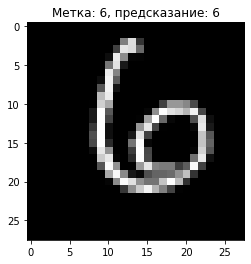

In [7]:
# Сетку обучили, визуализируем произвольную картинку

%matplotlib inline
import matplotlib.pyplot as plt

def visualize(idx):
    model.eval()
    image = test_dataset[idx][0].unsqueeze(0)
    label = test_dataset[idx][1]
    output = model(image)
    pred = output.detach().max(1)[1]
    plt.imshow(image[0][0],cmap='gray')
    plt.title(f'Метка: {label}, предсказание: {pred.item()}')
visualize(100)

In [8]:
# Теперь добавляем шум и атакуем нейросеть

def fgsm_attack(model, loss, images, labels, eps):
    images.requires_grad = True

    outputs = model(images.float())
    l = loss(outputs, labels.long())
    l.backward()

    attack_images= images + eps * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)

    return attack_images

In [10]:
correct = 0
total = 0
eps = 0.2

for test_x, test_label in test_loader:
    images = test_x
    labels = test_label
    attack_images = fgsm_attack(model, loss, images, labels, eps)

    outputs = model(attack_images.float())
    final_pred = outputs.max(1, keepdim=True)[1] # берем индекс с наибольшей вероятностью

    total = len(final_pred)
    for i in range(total):
        if final_pred[i].item() == labels[i].item():
            correct += 1

    print(f'Точность: {100 * float(correct) / total} %')
    break # только первый батч

Точность: 19.921875 %


In [ ]:
# Точность резко упала при eps = 0.2